# Topic: Music Genre Classification
Sound/Audio signals can be represented in the form of various parameters such 
as frequency, bandwidth, roll-off and so on. Using various python libraries, we can 
perform feature extraction for these audio signals. These features can then be 
processed and further used to perform classification.

In this project, we will use GTZAN dataset 
https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genreclassification which consists of 10 genre with 100 songs each, all having a length 
of 30 seconds. Given this dataset, our task is to:

Take two songs from each of the genre and visualize them and also find their
spectrogram.

a) Create a dataset by extracting feature for each of the songs in GTZAN dataset. 
For our task, we will specifically use the following features: Mel-Frequency 
Cepstral Coefficients, Spectral Centroid, Zero Crossing Rate, Chroma 
Frequencies and Spectral Roll-off.

b) Given total 1000 examples, perform K-Means-Clustering on the dataset to 
cross verify that the optimal number of clusters are 10 (one for each genre).

c) Divide the dataset into two parts: 90% train and 10% test i.e. for each genre 
use 90% of the dataset as train and the remaining as test dataset.

d) Perform classification using any of the four classification algorithms and 
compare the accuracy obtained. Study the architecture of the model used and 
describe the reason for the model with best accuracy.

In [1]:
# Import required libraries
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

## Dataset

GTZAN music genre dataset

In [2]:
audio_path = 'Data/genres_original/rock/rock.00000.wav'
x , sr = librosa.load(audio_path)

In [3]:
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [4]:
y, sry = librosa.load(audio_path, sr=44100)
print(y.shape, sry)

(1323588,) 44100


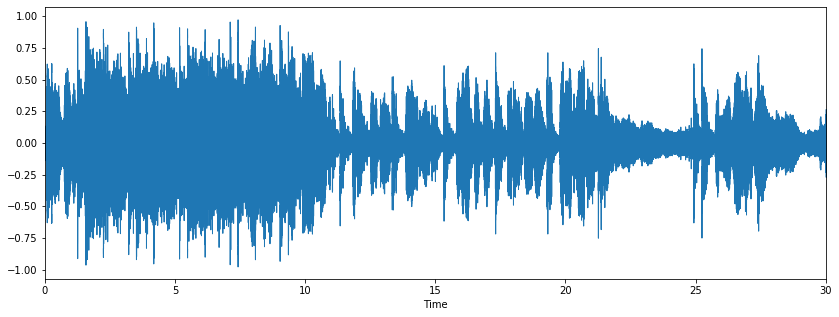

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

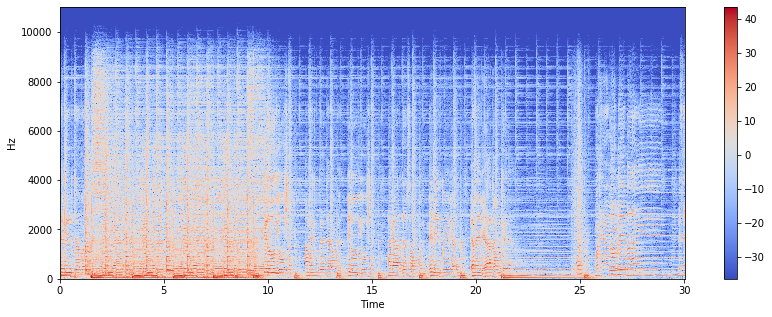

In [302]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Generating Spectral images of the Audio

In [8]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize = (10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'Data/images_original/{g}').mkdir(parents = True, exist_ok = True)
    for filename in os.listdir(f'Data/genres_original/{g}'):
        songname = 'Data/genres_original/'+g+'/'+filename
        y, sr = librosa.load(songname, mono = True, duration = 30)
        plt.specgram(y, 
                     NFFT = 2048,
                     Fs = 2,
                     Fc = 0,
                     noverlap = 128,
                     cmap = cmap,
                     sides = 'default',
                     mode = 'default',
                     scale = 'dB')
        plt.axis('off')
        plt.savefig(f'Data/images_original/{g}/{filename[:-3].replace(".","")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

### Extracting Audio features in csv file 

In [253]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1,21):
    header += f' mfcc_{i}'
header += ' label'
header = header.split()

In [10]:
file = open('data_new.csv', 'w', newline = '')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'Data/genres_original/{g}'):
        songname = 'Data/genres_original/'+g+'/'+filename
        y, sr = librosa.load(songname, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_ro = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spectral_cent)} {np.mean(spectral_bw)} {np.mean(spectral_ro)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data_new.csv', 'a', newline = '')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())        

In [5]:
# data = pd.read_csv('data_new.csv')
data = pd.read_csv('features_30_sec.csv')
data.head()


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
# Remove Filename and Length. Save to X and Y
data.pop('filename')
data.pop('length')
Y = pd.DataFrame(data.pop('label'))
X = data

In [7]:
X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [8]:
Y.head()

,label
0,blues
1,blues
2,blues
3,blues
4,blues


In [9]:
# Normalize the data
min_max = preprocessing.MinMaxScaler()
scaled_df = min_max.fit_transform(X.values)
final_df = pd.DataFrame(scaled_df,columns=X.columns)
final_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,...,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,...,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,...,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405
3,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,0.171001,...,0.565151,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168
4,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,0.180228,...,0.383289,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836


### K-Means Clustering

In [11]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

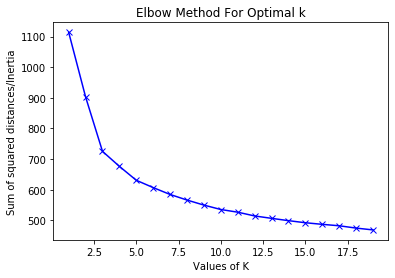

In [14]:
Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(final_df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

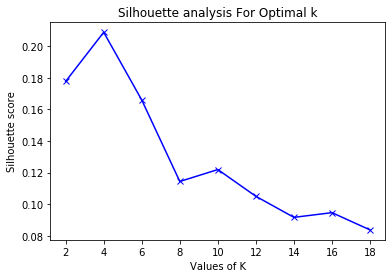

In [16]:
range_n_clusters = np.arange(2,20,2)
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(final_df)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(final_df, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### Modelling

In [16]:
# Convert Labels to one-Hot codes
cols = Y['label'].unique()
Y_encode = np.array(Y)
for i, item in enumerate(cols):
    ind = np.where(Y_encode == item)[0]
    Y_encode[ind] = i
Y_encode = pd.DataFrame(to_categorical(Y_encode))
Y_encode.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Split the Data into train and test
x_train, x_test, y_train, y_test = train_test_split(final_df, Y_encode, train_size = 0.9)
print('Length of x_train is : {}'.format(len(x_train)))
print('Length of y_train is : {}'.format(len(y_train)))
print('Length of x_test is : {}'.format(len(x_test)))
print('Length of y_test is : {}'.format(len(y_test)))

Length of x_train is : 900
Length of y_train is : 900
Length of x_test is : 100
Length of y_test is : 100


### Fitting a Neural Network

In [18]:
# Build the regular model
model = keras.Sequential()
model.add(layers.Input(shape = (np.array(x_train).shape[1],)))
model.add(layers.Dense(256, activation="relu"))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 17,418
Trainable params: 17,418
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [21]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=80, verbose = True)

Epoch 1/80
29/29 [==============================] - ETA: 1:23 - loss: 2.3170 - accuracy: 0.15 - ETA: 1s - loss: 2.3139 - accuracy: 0.1406 - ETA: 0s - loss: 2.2841 - accuracy: 0.12 - ETA: 1s - loss: 2.3059 - accuracy: 0.11 - ETA: 0s - loss: 2.2849 - accuracy: 0.15 - ETA: 0s - loss: 2.2807 - accuracy: 0.16 - ETA: 0s - loss: 2.2755 - accuracy: 0.17 - ETA: 1s - loss: 2.2699 - accuracy: 0.18 - ETA: 1s - loss: 2.2624 - accuracy: 0.19 - ETA: 1s - loss: 2.2594 - accuracy: 0.18 - ETA: 1s - loss: 2.2546 - accuracy: 0.19 - ETA: 1s - loss: 2.2561 - accuracy: 0.18 - ETA: 1s - loss: 2.2541 - accuracy: 0.18 - ETA: 1s - loss: 2.2524 - accuracy: 0.18 - ETA: 1s - loss: 2.2478 - accuracy: 0.19 - ETA: 0s - loss: 2.2440 - accuracy: 0.19 - ETA: 0s - loss: 2.2408 - accuracy: 0.19 - ETA: 0s - loss: 2.2374 - accuracy: 0.20 - ETA: 0s - loss: 2.2236 - accuracy: 0.20 - 9s 206ms/step - loss: 2.2225 - accuracy: 0.2067 - val_loss: 2.1197 - val_accuracy: 0.3400
Epoch 2/80
29/29 [==============================] - ETA:

29/29 [==============================] - ETA: 0s - loss: 0.9087 - accuracy: 0.68 - ETA: 3s - loss: 1.0426 - accuracy: 0.68 - ETA: 3s - loss: 1.0292 - accuracy: 0.70 - ETA: 2s - loss: 1.0649 - accuracy: 0.64 - ETA: 2s - loss: 0.9991 - accuracy: 0.67 - ETA: 2s - loss: 1.0158 - accuracy: 0.65 - ETA: 2s - loss: 1.0403 - accuracy: 0.65 - ETA: 2s - loss: 1.0348 - accuracy: 0.64 - ETA: 3s - loss: 1.0315 - accuracy: 0.64 - ETA: 3s - loss: 1.0234 - accuracy: 0.63 - ETA: 3s - loss: 1.0283 - accuracy: 0.63 - ETA: 2s - loss: 1.0055 - accuracy: 0.64 - ETA: 2s - loss: 1.0104 - accuracy: 0.64 - ETA: 2s - loss: 1.0062 - accuracy: 0.64 - ETA: 2s - loss: 1.0108 - accuracy: 0.64 - ETA: 2s - loss: 1.0051 - accuracy: 0.64 - ETA: 1s - loss: 0.9992 - accuracy: 0.65 - ETA: 1s - loss: 0.9949 - accuracy: 0.65 - ETA: 1s - loss: 0.9904 - accuracy: 0.65 - ETA: 1s - loss: 0.9904 - accuracy: 0.65 - ETA: 0s - loss: 0.9850 - accuracy: 0.65 - ETA: 0s - loss: 0.9861 - accuracy: 0.64 - ETA: 0s - loss: 0.9774 - accuracy: 

Epoch 34/80
29/29 [==============================] - ETA: 1s - loss: 0.8584 - accuracy: 0.68 - ETA: 0s - loss: 0.8875 - accuracy: 0.67 - ETA: 0s - loss: 0.9389 - accuracy: 0.67 - ETA: 0s - loss: 0.8992 - accuracy: 0.69 - ETA: 0s - loss: 0.9174 - accuracy: 0.67 - ETA: 0s - loss: 0.9026 - accuracy: 0.68 - ETA: 0s - loss: 0.8738 - accuracy: 0.69 - ETA: 0s - loss: 0.8924 - accuracy: 0.69 - ETA: 0s - loss: 0.8974 - accuracy: 0.69 - ETA: 0s - loss: 0.9053 - accuracy: 0.68 - ETA: 0s - loss: 0.8940 - accuracy: 0.70 - ETA: 0s - loss: 0.8871 - accuracy: 0.70 - ETA: 0s - loss: 0.8759 - accuracy: 0.71 - ETA: 0s - loss: 0.8779 - accuracy: 0.70 - ETA: 0s - loss: 0.8744 - accuracy: 0.70 - ETA: 0s - loss: 0.8754 - accuracy: 0.70 - ETA: 0s - loss: 0.8693 - accuracy: 0.70 - ETA: 0s - loss: 0.8690 - accuracy: 0.70 - 2s 53ms/step - loss: 0.8690 - accuracy: 0.7089 - val_loss: 0.9886 - val_accuracy: 0.6700
Epoch 35/80
29/29 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.65 - ETA: 0s

Epoch 48/80
29/29 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.75 - ETA: 0s - loss: 0.7375 - accuracy: 0.72 - ETA: 0s - loss: 0.7322 - accuracy: 0.72 - ETA: 0s - loss: 0.7328 - accuracy: 0.73 - ETA: 0s - loss: 0.7457 - accuracy: 0.73 - ETA: 0s - loss: 0.7427 - accuracy: 0.73 - ETA: 0s - loss: 0.7281 - accuracy: 0.75 - ETA: 0s - loss: 0.7324 - accuracy: 0.74 - ETA: 0s - loss: 0.7443 - accuracy: 0.74 - ETA: 0s - loss: 0.7462 - accuracy: 0.74 - ETA: 0s - loss: 0.7426 - accuracy: 0.74 - 1s 39ms/step - loss: 0.7439 - accuracy: 0.7433 - val_loss: 0.8837 - val_accuracy: 0.6900
Epoch 49/80
29/29 [==============================] - ETA: 0s - loss: 0.7597 - accuracy: 0.78 - ETA: 0s - loss: 0.7596 - accuracy: 0.74 - ETA: 0s - loss: 0.7559 - accuracy: 0.75 - ETA: 0s - loss: 0.7533 - accuracy: 0.75 - ETA: 0s - loss: 0.7517 - accuracy: 0.75 - ETA: 0s - loss: 0.7548 - accuracy: 0.75 - ETA: 0s - loss: 0.7496 - accuracy: 0.74 - ETA: 0s - loss: 0.7609 - accuracy: 0.74 - ETA: 0s

Epoch 61/80
29/29 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.84 - ETA: 0s - loss: 0.6455 - accuracy: 0.80 - ETA: 0s - loss: 0.6343 - accuracy: 0.81 - ETA: 0s - loss: 0.6399 - accuracy: 0.80 - ETA: 0s - loss: 0.6451 - accuracy: 0.80 - ETA: 0s - loss: 0.6646 - accuracy: 0.80 - ETA: 0s - loss: 0.6503 - accuracy: 0.81 - ETA: 0s - loss: 0.6551 - accuracy: 0.81 - ETA: 0s - loss: 0.6596 - accuracy: 0.80 - ETA: 0s - loss: 0.6625 - accuracy: 0.80 - ETA: 0s - loss: 0.6659 - accuracy: 0.80 - ETA: 0s - loss: 0.6690 - accuracy: 0.80 - ETA: 0s - loss: 0.6702 - accuracy: 0.79 - ETA: 0s - loss: 0.6796 - accuracy: 0.78 - ETA: 0s - loss: 0.6747 - accuracy: 0.78 - ETA: 0s - loss: 0.6735 - accuracy: 0.78 - 2s 54ms/step - loss: 0.6740 - accuracy: 0.7856 - val_loss: 0.8520 - val_accuracy: 0.7300
Epoch 62/80
29/29 [==============================] - ETA: 1s - loss: 0.6180 - accuracy: 0.75 - ETA: 0s - loss: 0.6264 - accuracy: 0.78 - ETA: 0s - loss: 0.6248 - accuracy: 0.78 - ETA: 1s

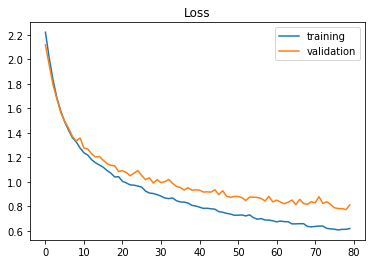

In [22]:
records = history.history
plt.plot(records['loss'], label="training")
plt.plot(records['val_loss'], label="validation")
plt.legend()
plt.title("Loss");

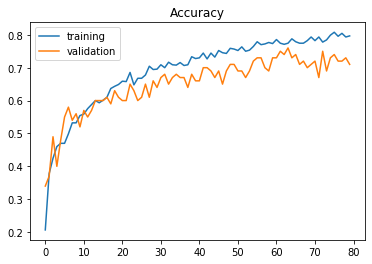

In [23]:
plt.plot(records['accuracy'], label="training")
plt.plot(records['val_accuracy'], label="validation")
plt.legend()
plt.title('Accuracy');

In [24]:
y_preds = np.round(model.predict(x_test))
y_preds[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [25]:
print(classification_report(y_test, np.array(y_preds), target_names = Y['label'].unique()))

C:\Users\patel\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       blues       1.00      0.55      0.71        11
   classical       1.00      0.91      0.95        11
     country       0.88      0.70      0.78        10
       disco       1.00      0.50      0.67         6
      hiphop       1.00      0.42      0.59        12
        jazz       0.91      0.77      0.83        13
       metal       0.67      0.75      0.71         8
         pop       0.88      0.88      0.88         8
      reggae       0.44      0.40      0.42        10
        rock       0.40      0.36      0.38        11

   micro avg       0.78      0.62      0.69       100
   macro avg       0.82      0.62      0.69       100
weighted avg       0.82      0.62      0.69       100
 samples avg       0.62      0.62      0.62       100



#### Using Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
cols_clf = Y['label'].unique()
Y_encode_clf = np.array(Y)
for i, item in enumerate(cols_clf):
    ind = np.where(Y_encode_clf == item)[0]
    Y_encode_clf[ind] = i
Y_encode_clf = Y_encode_clf.reshape(1,1000)[0]
Y_encode_clf[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [28]:
# Split the Data into train and test
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(final_df, Y, train_size = 0.9)
print('Length of x_train is : {}'.format(len(x_train_clf)))
print('Length of y_train is : {}'.format(len(y_train_clf)))
print('Length of x_test is : {}'.format(len(x_test_clf)))
print('Length of y_test is : {}'.format(len(y_test_clf)))

Length of x_train is : 900
Length of y_train is : 900
Length of x_test is : 100
Length of y_test is : 100


In [36]:
clf = RandomForestClassifier(n_estimators = 200, random_state = 22)
clf.fit(x_train_clf, y_train_clf)
preds = clf.predict(x_test_clf)
preds = preds.reshape((100,1))
print(f'Accuracy of the predictor is: {(preds == y_test_clf).sum()[0]}%')

C:\Users\patel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy of the predictor is: 82%
